## Linear Models
Try again to use LinearRegression() and Lasso() models based off of input from Kaggle [forum](https://www.kaggle.com/c/allstate-claims-severity/forums/t/24749/linear-models-predicting-very-large-values).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from copy import deepcopy
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

In [2]:
loc = '/Users/elena/Documents/Kaggle/Allstate/data/'
#loc = '/Users/elenaw/Documents/Kaggle/Allstate/data/'

train = pd.read_csv(os.path.join(loc,'train.csv'))
train.drop('id',axis=1,inplace=True)

test = pd.read_csv(os.path.join(loc,'test.csv'))
ids = test['id']
test.drop('id',axis=1,inplace=True)

submission = pd.read_csv(os.path.join(loc,"sample_submission.csv"))

In [3]:
# List of categorical columns
keepcats = [col for col in train.columns if 'cat' in col]
# List of continuous columns
keepcont = [col for col in train.columns if 'cont' in col]

print 'Categorical: ',len(keepcats)
print 'Continuous: ',len(keepcont)

Categorical:  116
Continuous:  14


In [4]:
# Remove some highly correlated continuous features:
newlist = deepcopy(keepcont)
newlist.remove("cont1")
newlist.remove("cont11")
newlist.remove("cont6")

# Take the logarithm of the 'loss' column. 
dataset_cont = train[newlist]
dataset_cont['log-loss']=np.log1p(train['loss'].values)
dataset_cont.head()

/Users/elena/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,cont14,log-loss
0,0.245921,0.187583,0.789639,0.310061,0.335060,0.30260,0.67135,0.83510,0.594646,0.822493,0.714843,7.702637
1,0.737068,0.592681,0.614134,0.885834,0.436585,0.60087,0.35127,0.43919,0.366307,0.611431,0.304496,7.158203
2,0.358319,0.484196,0.236924,0.397069,0.315545,0.27320,0.26076,0.32446,0.373424,0.195709,0.774425,8.008396
3,0.555782,0.527991,0.373816,0.422268,0.391128,0.31796,0.32128,0.44467,0.321570,0.605077,0.602642,6.846784
4,0.159990,0.527991,0.473202,0.704268,0.247408,0.24564,0.22089,0.21230,0.202213,0.246011,0.432606,7.924742


In [5]:
def convert_strings(pdseries):
    # Function inputs a column of a pandas DataFrame,
    # determines the number of unique entries, and assigns 
    # an integer to each entry. 
    # This is to avoid issues with non-integer data.
      
    array = np.array(pdseries)
    vals = np.unique(array)
    nums = np.arange(0,len(vals),1)
    #new_array = np.zeros(len(array),dtype='int')     
    new_array = np.zeros(len(array),dtype='float')
    
    #nums = np.linspace(0,1,len(vals))
    #new_array = np.zeros(len(array))

    for j in range(len(vals)):
        ind = np.where(array==vals[j])[0]
        new_array[ind]=nums[j]
     
    # Returns a numpy array with an integer for each entry
    return new_array

/Users/elena/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/elena/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


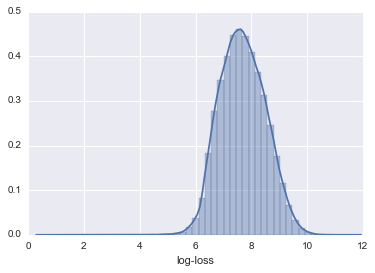

In [6]:
# Based on analysis presented in Kaggle forum, get rid of a couple highly
# correlated categorical variables:
#get_rid_of = list(['cat2-','cat6-','cat8-','cat7-','cat16-'])
new_cat_list = deepcopy(keepcats)
new_cat_list.remove("cat2")
new_cat_list.remove("cat6")
new_cat_list.remove("cat8")
new_cat_list.remove("cat7")
new_cat_list.remove("cat16")

dataset_cat = train[new_cat_list]
test_cat = test[new_cat_list]

# Use the concatenated list of test and train categorical data
# so we know the number of unique variables that are found
# in each category.
full_cat = pd.concat([dataset_cat,test_cat],ignore_index=True)

for cat in new_cat_list:
    converted = convert_strings(full_cat.loc[:,cat])
    dataset_cat.loc[:,cat]=converted[0:len(dataset_cat)]
    test_cat.loc[:,cat]=converted[len(dataset_cat):]
    

final_data = pd.concat([dataset_cont,dataset_cat],axis=1)
y = final_data['log-loss']
x = final_data.drop('log-loss',axis=1)

sns.distplot(y)

In [7]:
final_data.head()

,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0.245921,0.187583,0.789639,0.310061,0.335060,0.30260,0.67135,0.83510,0.594646,0.822493,...,9.0,6.0,46.0,28.0,2.0,19.0,57.0,0.0,14.0,288.0
1,0.737068,0.592681,0.614134,0.885834,0.436585,0.60087,0.35127,0.43919,0.366307,0.611431,...,10.0,10.0,34.0,67.0,0.0,22.0,39.0,0.0,14.0,94.0
2,0.358319,0.484196,0.236924,0.397069,0.315545,0.27320,0.26076,0.32446,0.373424,0.195709,...,5.0,0.0,2.0,87.0,0.0,28.0,6.0,0.0,8.0,167.0
3,0.555782,0.527991,0.373816,0.422268,0.391128,0.31796,0.32128,0.44467,0.321570,0.605077,...,10.0,10.0,34.0,69.0,2.0,39.0,5.0,0.0,14.0,88.0
4,0.159990,0.527991,0.473202,0.704268,0.247408,0.24564,0.22089,0.21230,0.202213,0.246011,...,6.0,1.0,67.0,51.0,2.0,50.0,39.0,0.0,10.0,63.0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.8)

newmodel = LinearRegression()
newmodel.fit(X_train,y_train)
pred = newmodel.predict(X_test)
print mean_absolute_error(np.expm1(y_test),np.expm1(pred))

newnew = LinearRegression(normalize=True)
newnew.fit(X_train,y_train)
pred2 = newnew.predict(X_test)
print mean_absolute_error(np.expm1(y_test),np.expm1(pred2))


1305.5304889
1305.57855121


In [9]:
full_list = newlist+new_cat_list
test_dataset = test[full_list]

for cat in new_cat_list:
    test_dataset.loc[:,cat]=convert_strings(test_dataset.loc[:,cat])
test_dataset.head()

,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0.299102,0.246911,0.402922,0.281143,0.317681,0.61229,0.34365,0.38016,0.369858,0.704052,...,11.0,10.0,30.0,26.0,0.0,35.0,23.0,0.0,16.0,169.0
1,0.620805,0.654310,0.946616,0.836443,0.443760,0.71330,0.51890,0.60401,0.675759,0.453468,...,5.0,1.0,30.0,58.0,3.0,32.0,58.0,0.0,11.0,173.0
2,0.737068,0.711159,0.412789,0.718531,0.325779,0.29758,0.34365,0.30529,0.241676,0.258586,...,6.0,0.0,30.0,62.0,2.0,46.0,4.0,0.0,10.0,51.0
3,0.681761,0.592681,0.354893,0.397069,0.342355,0.40028,0.33237,0.31480,0.341872,0.592264,...,10.0,10.0,30.0,61.0,0.0,25.0,9.0,0.0,15.0,76.0
4,0.299102,0.263570,0.696873,0.302678,0.391833,0.23688,0.43731,0.50556,0.352251,0.301535,...,4.0,1.0,2.0,100.0,0.0,30.0,45.0,2.0,9.0,163.0


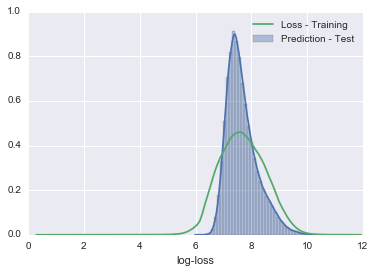

In [10]:
# Use full dataset to make a model
model = LinearRegression()
model.fit(x,y)

submission.iloc[:, 1] = np.expm1(model.predict(test_dataset))
#submission.to_csv(loc+'linear_reg1.csv', index=None)

fig,ax = plt.subplots()
sns.distplot(model.predict(test_dataset),ax=ax,label='Prediction - Test')
sns.distplot(y,hist=False,ax=ax,label='Loss - Training')
plt.legend()

## Lasso

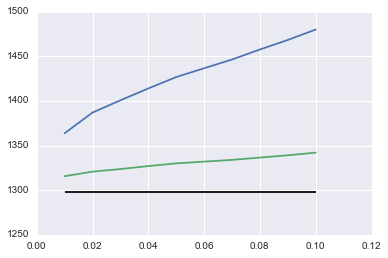

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.25)

alphas = np.linspace(0.01,0.1,10)

maes = []
maes_avg = []
for a in alphas:
    model = Lasso(alpha=a)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    maes.append(mean_absolute_error(np.expm1(y_test),np.expm1(pred)))
    
    model2 = LinearRegression()
    model2.fit(X_train,y_train)
    pred2 = model2.predict(X_test)
    maes_avg.append(mean_absolute_error(np.expm1(y_test),np.expm1((pred+pred2)/2.0)))
    
plt.plot(alphas,maes)
plt.hlines(1298,0.01,0.1)
plt.plot(alphas,maes_avg)

In [12]:
ys = dataset_cont['log-loss']
xs = dataset_cont.drop('log-loss',axis=1)

X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=.25)

model1 = LinearRegression()
model1.fit(X_train,y_train)

model2 = Lasso()
model2.fit(X_train,y_train)

print mean_absolute_error(np.expm1(y_test),np.expm1(model1.predict(X_test)))
print mean_absolute_error(np.expm1(y_test),np.expm1(model2.predict(X_test)))

1788.70076508
1795.27310076


## Ridge

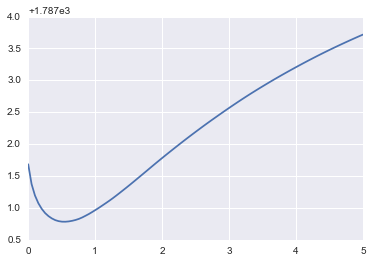

In [13]:
y = final_data['log-loss']
x = final_data.drop('log-loss',axis=1)
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=.25)


alphas = np.linspace(1e-9,5,100)
maes = []
for a in alphas:
    model = Ridge(alpha=a,normalize=True)
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    maes.append(mean_absolute_error(np.expm1(y_test),np.expm1(pred)))
    
plt.plot(alphas,maes)


## Loop through various models
Adding features one at a time

cont10  Linear MAE dropped by  31.6172514374
cont10  Ridge MAE dropped by  31.404271229
cat1  Linear MAE dropped by  59.7642102907
cat1  Ridge MAE dropped by  57.5432388131
cat3  Linear MAE dropped by  25.0454603264
cat3  Ridge MAE dropped by  20.7670858583
cat4  Linear MAE dropped by  43.2227897634
cat4  Ridge MAE dropped by  43.6339639143
cat5  Linear MAE dropped by  24.3232572
cat9  Linear MAE dropped by  56.3162349101
cat9  Ridge MAE dropped by  52.9739158373
cat10  Linear MAE dropped by  39.6337674056
cat10  Ridge MAE dropped by  45.4643772008
cat12  Linear MAE dropped by  33.689814936
cat12  Ridge MAE dropped by  37.3832230474
cat27  Linear MAE dropped by  23.8912359552
cat27  Ridge MAE dropped by  22.9270253492
cat35  Linear MAE dropped by  24.2894770247
cat35  Ridge MAE dropped by  26.4982884299
cat37  Linear MAE dropped by  23.040222931
cat37  Ridge MAE dropped by  22.5980523995
cat50  Linear MAE dropped by  23.9586649307
cat59  Linear MAE dropped by  59.6490362475
cat59  Ridg

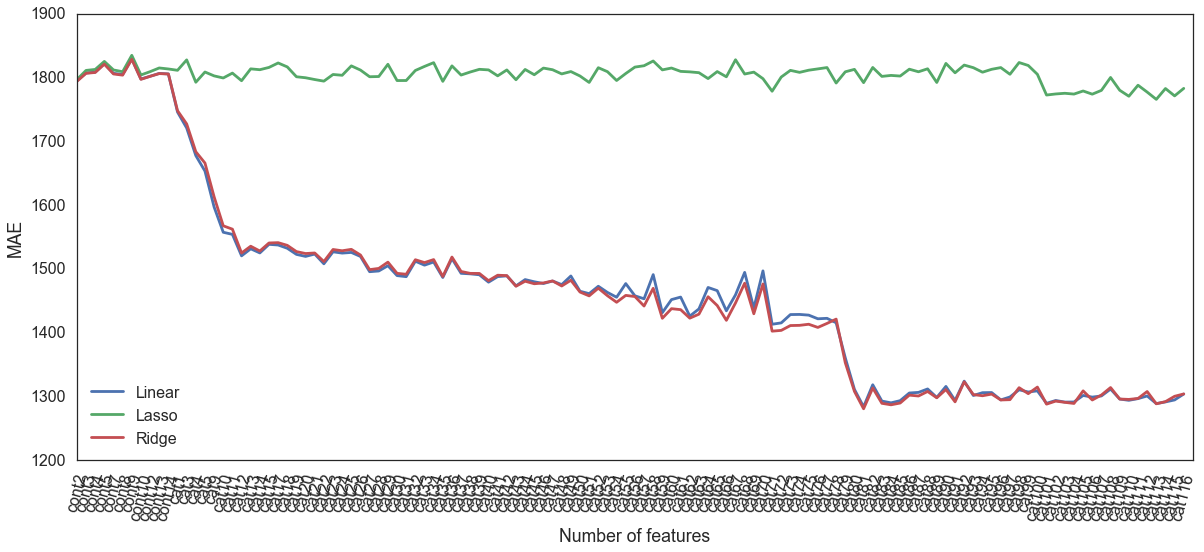

In [24]:
list_of_vars = list(final_data.columns)
list_of_vars.remove('log-loss')


mae_linear = []
mae_lasso = []
mae_randomf = []
mae_ridge = []

y = final_data['log-loss']

df = pd.DataFrame()
for l in range(len(list_of_vars)):
    df[list_of_vars[l]] = final_data[list_of_vars[l]]
    
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=.25)

    # Linear Regression
    m1 = LinearRegression()
    m1.fit(X_train,y_train)
    pred1 = m1.predict(X_test)
    mae_linear.append(mean_absolute_error(np.expm1(y_test),np.expm1(pred1)))
    
    if (l>=1):
        if ((mae_linear[-2] - mae_linear[-1]) > 20):
            print list_of_vars[l],' Linear MAE dropped by ',mae_linear[-2]-mae_linear[-1]
    
    # Lasso
    m2 = Lasso()
    m2.fit(X_train,y_train)
    pred2 = m2.predict(X_test)
    mae_lasso.append(mean_absolute_error(np.expm1(y_test),np.expm1(pred2)))
    
#     # Random Forest
#     m3 = RandomForestRegressor(min_samples_split=5)
#     m3.fit(X_train,y_train)
#     pred3 = m3.predict(X_test)
#     mae_randomf.append(mean_absolute_error(np.expm1(y_test),np.expm1(pred3)))
    
    # Ridge
    m4 = Ridge(alpha=0.2,normalize=True)
    m4.fit(X_train,y_train)
    pred4 = m4.predict(X_test)
    mae_ridge.append(mean_absolute_error(np.expm1(y_test),np.expm1(pred4)))
    
    if (l>=1):
        if ((mae_ridge[-2] - mae_ridge[-1]) > 20):
            print list_of_vars[l],' Ridge MAE dropped by ',mae_ridge[-2]-mae_ridge[-1]
    
    
    
sns.set_context('poster')
sns.set_style('white')
plt.figure(figsize=(20,8))
plt.plot(mae_linear,label='Linear')
plt.plot(mae_lasso,label='Lasso')
#plt.plot(mae_randomf,label='Random Forest')
plt.plot(mae_ridge,label='Ridge')
plt.legend(loc='best')
plt.ylabel('MAE')
plt.xlabel('Number of features')
plt.xlim([0,len(list_of_vars)])
ax = plt.gca()
ax.set_xticks(np.arange(0,len(list_of_vars)));
ax.set_xticklabels(list_of_vars,rotation=75);

### Try only important features
As defined from the image above.

In [35]:
#important = list(["cont2","cat1","cat9","cat57","cat59","cat80","cat97"])
important = list(["cont10","cat1","cat3","cat4","cat9",
                  "cat10","cat12","cat27","cat35","cat37",
                  "cat59","cat66","cat69","cat71","cat79",
                  "cat80","cat81","cat83"])

keep_df = final_data[important]

X_train, X_test, y_train, y_test = train_test_split(keep_df, y, test_size=.8)

# Linear Regression
m1 = LinearRegression(normalize=True)
m1.fit(X_train,y_train)
pred1 = m1.predict(X_test)
print 'Was 1479,',mean_absolute_error(np.expm1(y_test),np.expm1(pred1))

# Linear Regression
m2 = Ridge(alpha=0.2,normalize=True)
m2.fit(X_train,y_train)
pred2 = m2.predict(X_test)
print 'Was 1499,',mean_absolute_error(np.expm1(y_test),np.expm1(pred2))

print mean_absolute_error(np.expm1(y_test),np.expm1((pred1+pred2)/2.0))

Was 1479, 1410.98689137
Was 1499, 1417.540564
1412.72276256


In [36]:
normal_features = deepcopy(keep_df)
normal_features['cont10']=np.log1p(normal_features['cont10'])

X_train, X_test, y_train, y_test = train_test_split(normal_features, y, test_size=.3)

# Linear Regression
m1 = LinearRegression(normalize=True)
m1.fit(X_train,y_train)
pred1 = m1.predict(X_test)
print mean_absolute_error(np.expm1(y_test),np.expm1(pred1))

# Linear Regression
m2 = Ridge(alpha=0.2,normalize=True)
m2.fit(X_train,y_train)
pred2 = m2.predict(X_test)
print mean_absolute_error(np.expm1(y_test),np.expm1(pred2))


1407.33810318
1412.9510733
